In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

['.DS_Store', 'test', 'train']


In [2]:
data_root = 'input'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [3]:
import shutil 
from tqdm.notebook import tqdm


# создаём обучающую и валидационную выборки
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:  # каждую 6 картинку кладём в папку для валидации
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [4]:
print('len train data class 0: ', len(os.listdir('train/cleaned/')))
print('len train data class 1: ', len(os.listdir('train/dirty/')))
print('len val data class 0: ', len(os.listdir('val/cleaned/')))
print('len val data class 1: ', len(os.listdir('val/dirty/')))

len train data class 0:  231
len train data class 1:  237
len val data class 0:  48
len val data class 1:  51


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

# случайным образом вырезаем на картинке область 224 на 224
# зеркальное отображение по горизонтали
# переводим из pillow в tensor
# нормализуем с параметрами МО и СКО для resnet18 для каждого канала RGB
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# сжимаем изображение до 224 на 224
# переводим из pillow в tensor
# нормализуем с параметрами МО и СКО для resnet18 для каждого канала RGB
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ImageFolder позваляет итерироваться по датасету
# он выдает картинку и метку класса (название папки clean/dirty)
# первый аргумент - папка с подпапками классов, второй аргумент - функция трансформации данных
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
# создание объекта загрузчика данных
# принимает набор данных, размер батча, перемешивание, кол-во подпроцессов обработки данных
# drop_last=True говорит о том, что надо удалить последний неполный батч
# получается 4 раза выводит тензор с размерами (8, 3, 224, 224) и метками (8)
# без drop_last=True 4 раза выводит тензор с размерами (8, 3, 224, 224) и 1 раз (2, 3, 224, 224)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size, drop_last=False)

In [6]:
next(iter(train_dataloader))

[tensor([[[[ 0.3994,  0.4166,  0.4337,  ..., -0.2856, -0.2513, -0.2342],
           [ 0.3994,  0.4166,  0.4337,  ..., -0.2171, -0.1828, -0.1657],
           [ 0.3994,  0.4166,  0.4508,  ...,  0.0227,  0.0569,  0.0569],
           ...,
           [ 1.0159,  1.0159,  0.9988,  ..., -0.7650, -0.7822, -0.7822],
           [ 1.0159,  1.0159,  0.9988,  ..., -0.7308, -0.7308, -0.7308],
           [ 1.0159,  1.0159,  0.9988,  ..., -0.7137, -0.7137, -0.7137]],
 
          [[ 0.4153,  0.4153,  0.4328,  ..., -0.3550, -0.2850, -0.2675],
           [ 0.4153,  0.4153,  0.4328,  ..., -0.2850, -0.2150, -0.1975],
           [ 0.4153,  0.4328,  0.4503,  ..., -0.0224,  0.0301,  0.0476],
           ...,
           [ 1.1856,  1.1856,  1.1681,  ..., -0.8452, -0.8452, -0.8452],
           [ 1.1856,  1.1856,  1.1681,  ..., -0.8102, -0.8102, -0.8102],
           [ 1.1856,  1.1856,  1.1681,  ..., -0.8102, -0.8102, -0.8102]],
 
          [[ 0.3219,  0.3393,  0.3742,  ...,  0.1825,  0.2522,  0.2871],
           [ 

In [6]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

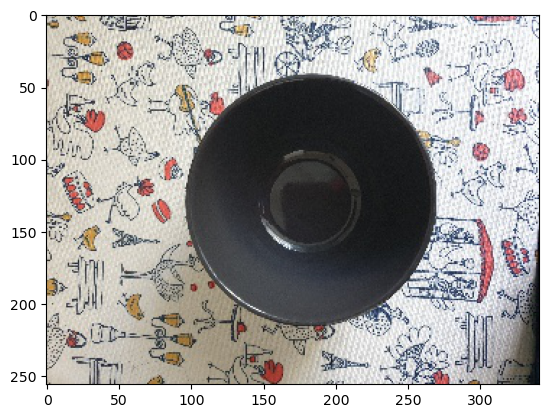

In [7]:
plt.imshow(torchvision.datasets.ImageFolder(train_dir)[0][0])

In [8]:
len(train_dataloader), len(train_dataset)

(4, 34)

In [9]:
len(val_dataloader), len(val_dataset)

(1, 6)

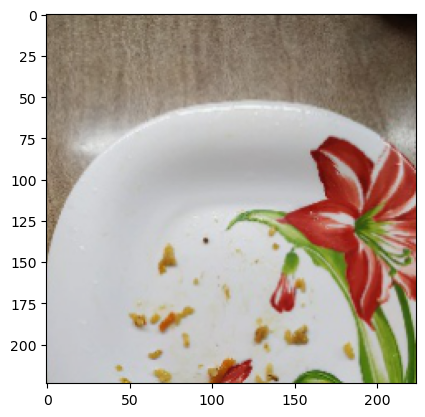

In [10]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# обратное преобразование для отображения картинки
# меняем местами размерность (3, 224, 224) на (224, 224, 3)
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))    # clip(0, 1) -1, 0, 1, 2 -> 0, 0, 1, 1
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [12]:
def train_model(model, loss, optimizer, scheduler, num_epochs, device):

    val_loss_history = []
    val_accuracy_history = []
    train_loss_history = []
    train_accuracy_history = []

    for epoch in (pbar := tqdm(range(num_epochs))):
        # каждая эпоха имеет этап обучения и проверки
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()    # говорим планировщику что прошла 1 эпоха
                model.train()  # переводим модель в train mode
            else:
                dataloader = val_dataloader
                model.eval()   # переводим модель в evaluate mode

            running_loss = 0.
            running_acc = 0.

            # итерируемся по данным
            for inputs, labels in dataloader:
                inputs = inputs.to(device)  # переводим инпуты на device
                labels = labels.to(device)  # переводим метки на device

                optimizer.zero_grad()   # обнуляем градиент, чтобы он не накапливался

                # forward and backward
                # set_grad_enabled не сохраняет подсчет градиентов для фазы валидации
                # set_grad_enabled выполняет то же самое, что и torch.no_grad()
                # set_grad_enabled удобнее использовать, чтобы не повторять код для forward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()   # считаем градиент 
                        optimizer.step()    # считаем шаг градиентного спуска

                # накапливаем метрики для каждого батча
                running_loss += loss_value.item()   # item переводит на cpu
                running_acc += (preds_class == labels.data).float().mean().item()   # item переводит на cpu

            # считаем средние метрики для одной эпохи
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)
            else:
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)

            pbar.set_description(f'Epoch: {epoch}')
            pbar.set_postfix_str(f'Accuracy: {epoch_acc: .3f}, \
                                 Loss: {epoch_loss: .3f}, GPU_Mem_alloc: {torch.cuda.memory_allocated()/1000000: .3f} MB, \
                                 GPU_Mem_cashed: {torch.cuda.memory_reserved()/1000000: .3f} MB')

    return val_accuracy_history, val_loss_history, train_accuracy_history, train_loss_history, model

accuracies = {}
losses = {}

In [13]:
len(val_dataloader)

1

In [14]:
models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# берем обученную модель
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# замораживаем веса (полезно когда маленький датасет)
for param in model.parameters():
    param.requires_grad = False

# меняем последний fc слой, который содержал 1000 выходов
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)   # amsgrad

# уменьшение LR в 0.1 раза каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
accuracies['val_resnet18_1fc'], losses['val_resnet18_1fc'], accuracies['train_resnet18_1fc'], losses['train_resnet18_1fc'], net = \
    train_model(model, loss, optimizer, scheduler, num_epochs=10, device=device)

Text(0.5, 1.0, 'Accuracy')

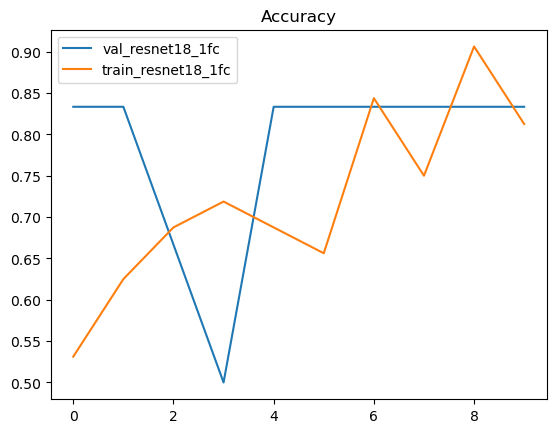

In [17]:
import matplotlib.pyplot  as plt

for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

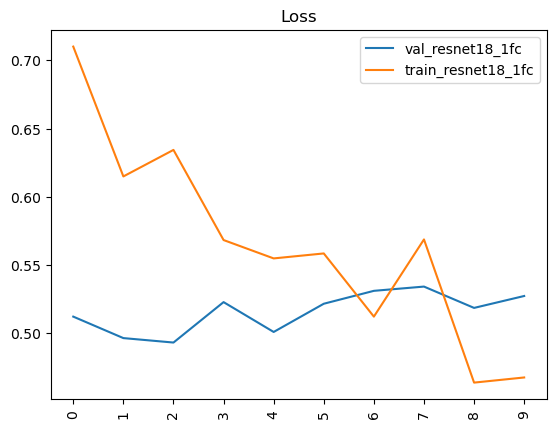

In [18]:
import matplotlib.pyplot as plt

for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
    plt.xticks(np.arange(len(losses[experiment_id])), rotation=90)
plt.legend()
plt.title('Loss')

In [103]:
test_dir = 'input/test/'
# создаем подпапку в папке test (чтобы imagefolder думал что это класс unknown)
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'input/test/unknown'

In [104]:
# необходимо переписать ImageFolder, чтобы он ещё выдавал имя (путь) к изображению
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('input/test/', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [105]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: input/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [106]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:08<00:00, 11.60it/s]


In [107]:
len(test_predictions)

744

In [108]:
len(test_img_paths)

744

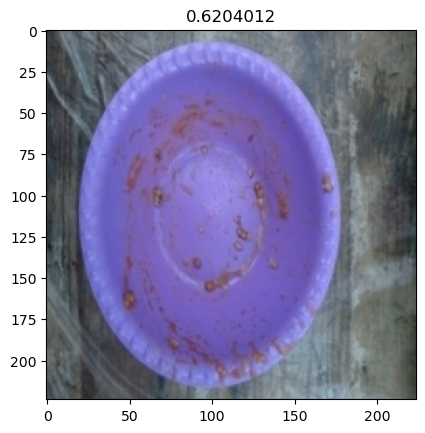

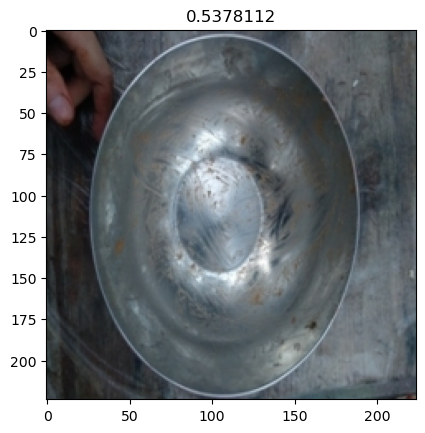

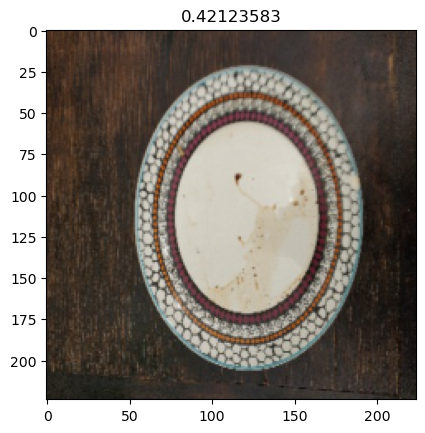

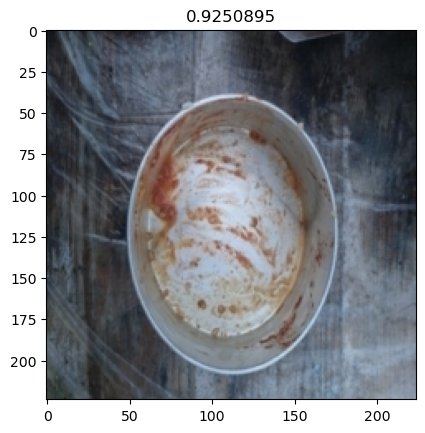

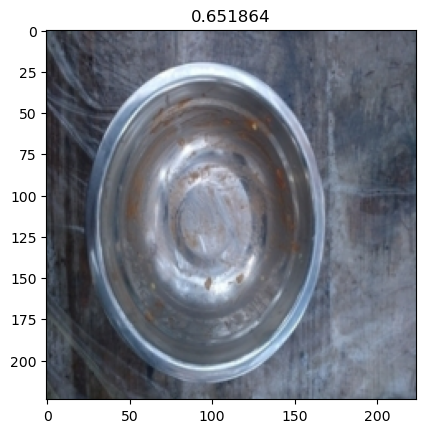

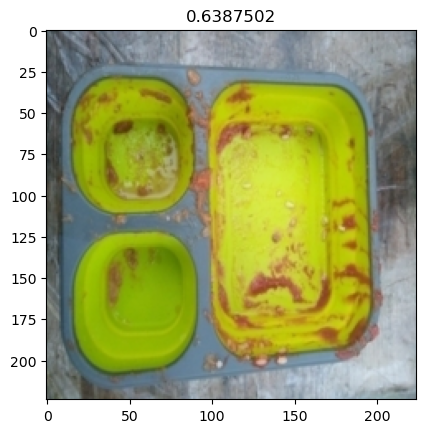

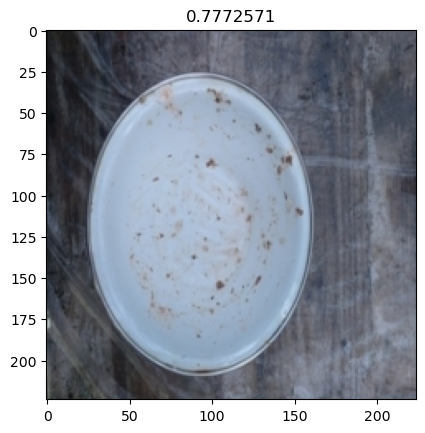

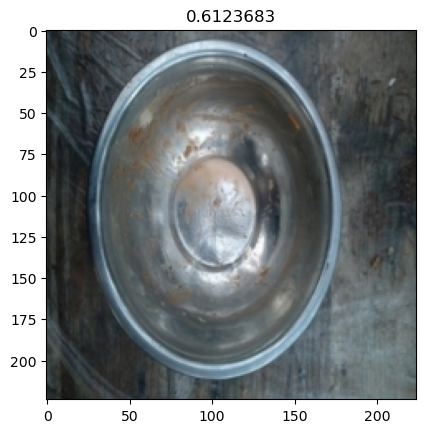

In [109]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [110]:
test_img_paths

['input/test/unknown\\0000.jpg',
 'input/test/unknown\\0001.jpg',
 'input/test/unknown\\0002.jpg',
 'input/test/unknown\\0003.jpg',
 'input/test/unknown\\0004.jpg',
 'input/test/unknown\\0005.jpg',
 'input/test/unknown\\0006.jpg',
 'input/test/unknown\\0007.jpg',
 'input/test/unknown\\0008.jpg',
 'input/test/unknown\\0009.jpg',
 'input/test/unknown\\0010.jpg',
 'input/test/unknown\\0011.jpg',
 'input/test/unknown\\0012.jpg',
 'input/test/unknown\\0013.jpg',
 'input/test/unknown\\0014.jpg',
 'input/test/unknown\\0015.jpg',
 'input/test/unknown\\0016.jpg',
 'input/test/unknown\\0017.jpg',
 'input/test/unknown\\0018.jpg',
 'input/test/unknown\\0019.jpg',
 'input/test/unknown\\0020.jpg',
 'input/test/unknown\\0021.jpg',
 'input/test/unknown\\0022.jpg',
 'input/test/unknown\\0023.jpg',
 'input/test/unknown\\0024.jpg',
 'input/test/unknown\\0025.jpg',
 'input/test/unknown\\0026.jpg',
 'input/test/unknown\\0027.jpg',
 'input/test/unknown\\0028.jpg',
 'input/test/unknown\\0029.jpg',
 'input/te

In [111]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [112]:
submission_df

,id,label
0,input/test/unknown\0000.jpg,0.620401
1,input/test/unknown\0001.jpg,0.537811
2,input/test/unknown\0002.jpg,0.421236
3,input/test/unknown\0003.jpg,0.925089
4,input/test/unknown\0004.jpg,0.651864
...,...,...
739,input/test/unknown\0739.jpg,0.745795
740,input/test/unknown\0740.jpg,0.694649
741,input/test/unknown\0741.jpg,0.397540
742,input/test/unknown\0742.jpg,0.396038


In [118]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace(r"input/test/unknown\\", '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

C:\Users\zekat\AppData\Local\Temp\ipykernel_12416\3866547878.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace(r"input/test/unknown\\", '')
C:\Users\zekat\AppData\Local\Temp\ipykernel_12416\3866547878.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [119]:
submission_df.to_csv('submission.csv')

In [39]:
import shutil

try:
    shutil.rmtree('train/')
    shutil.rmtree('val/')
    shutil.rmtree('input/test/unknown')
except FileNotFoundError:
    print('Пути уже удалены')

Пути уже удалены
